### Dependencies

In [10]:
# pip install delayed
# !pip install scikit-survival

     |████████████████████████████████| 85 kB 889 kB/s            
     |████████████████████████████████| 72 kB 430 kB/s            
Note: you may need to restart the kernel to use updated packages.


### Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
import matplotlib.pyplot as plt

### Loading and Cleaning dataset

In [3]:
df = pd.read_csv("selected.csv", index_col = False)
df.drop(["Unnamed: 0"], inplace = True, axis = 1)
df = df.replace(' NA', np.nan)
df = df.replace('NA', np.nan)
df['NPI'] = df['NPI'].astype('float')
df['NPI'].replace(np.nan, df['NPI'].mean(), inplace = True)
df.head()

,219340_s_at,217771_at,202418_at,206295_at,201091_s_at,204015_s_at,200726_at,200965_s_at,210314_x_at,221882_s_at,...,t.dmfs,e.dmfs,t.tdm,e.tdm,risksg,NPI,risknpi,AOL_os_10y,risk_AOL,veridex_risk
0,7.014110,9.938705,11.053083,5.326001,10.964107,6.244280,10.926361,8.962608,10.523859,10.926365,...,723,1,723,1,2,4.60,2,62.7,1,Poor
1,7.326724,6.374728,10.596457,8.290123,11.594716,6.542130,12.242090,9.531718,10.342614,9.555092,...,6591,0,6591,0,2,4.60,2,69.0,1,Poor
2,6.974651,9.226757,10.834848,5.731169,9.166088,6.586000,11.661716,10.238680,10.144875,9.308048,...,524,1,524,1,2,4.50,2,66.2,1,Poor
3,7.703683,8.169183,11.627066,8.538247,9.086937,8.477335,12.174021,9.819279,10.888251,10.208241,...,6255,1,6255,0,2,4.36,2,84.9,1,Poor
4,6.581141,7.496745,11.500773,5.979282,8.887616,7.398170,11.484011,11.489233,9.702690,10.931843,...,3822,1,3822,1,2,3.60,2,80.2,1,Poor


In [4]:
df.isna().sum(axis = 0).sort_values()[-10:]

203391_at        0
204768_s_at      0
208180_s_at      0
217815_at        0
risksg           1
risknpi          2
grade            2
Histtype         4
Angioinv        77
Lymp_infil     117
dtype: int64

### Choosing columns for training

In [5]:
removals = ['t.rfs', 'e.rfs', 't.os', 'e.os', 't.dmfs','e.dmfs', 't.tdm', 'e.tdm', "samplename", "id","filename","hospital", 'Surgery_type', 'Histtype', 'Angioinv', 'Lymp_infil', 'node', 'grade', 'er', 'risksg', 'risknpi', 'risk_AOL', 'veridex_risk']
rest = [i for i in df.columns if i not in removals]

### Defining Explanatory and Response Variable

In [6]:
X = df[rest]
y = pd.DataFrame(df[['e.tdm', 't.tdm']])
y.columns = ['event', 'time']
y['event'] = y['event'] == 1
y = [tuple(row) for row in y.values]
out = np.empty(len(y), dtype =[('fstat', '?'), ('lenfol', '<f8')])
out[:] = y
out

array([( True,  723.), (False, 6591.), ( True,  524.), (False, 6255.),
       ( True, 3822.), (False, 6507.), (False, 5947.), (False, 5816.),
       (False, 6007.), ( True, 1233.), ( True, 1136.), (False, 5984.),
       (False, 6249.), ( True, 4066.), ( True,  690.), ( True,  994.),
       ( True,  434.), ( True, 1743.), ( True, 2863.), (False, 5693.),
       (False, 5823.), (False, 5785.), (False, 5661.), (False, 2909.),
       ( True, 1171.), (False, 5110.), (False, 5533.), (False, 5571.),
       (False, 5519.), (False, 5379.), (False, 4675.), (False, 4652.),
       (False, 4227.), ( True,  910.), (False, 4472.), ( True, 1206.),
       (False, 7057.), (False,  958.), (False, 5359.), (False, 5945.),
       (False, 5651.), ( True,  528.), ( True,  796.), (False, 5685.),
       ( True, 1023.), (False, 4791.), (False, 1215.), (False, 3779.),
       (False, 5306.), (False, 5678.), ( True,  421.), (False, 5612.),
       ( True, 3121.), (False, 1104.), (False, 4691.), (False, 5238.),
      

### Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, out, test_size=0.50, random_state=42)

### Fitting Random Survival Forest

In [8]:
rsf = RandomSurvivalForest(n_estimators = 1000, 
                          min_samples_split=10, 
                          min_samples_leaf=15,
                          max_features="sqrt", 
                          random_state=0)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, random_state=0)

### Score

In [9]:
rsf.score(X_test, y_test)

0.665868263473054

### Predicting and Plotting Cumulative Hazard Function

In [10]:
chf = rsf.predict_cumulative_hazard_function(X_test, return_array=True)
chf

array([[0.00431992, 0.01116434, 0.01726432, ..., 0.18285761, 0.21326457,
        0.22894807],
       [0.01394193, 0.02559209, 0.03595799, ..., 0.30334373, 0.33289709,
        0.36968292],
       [0.00862591, 0.02160779, 0.03642167, ..., 0.25171091, 0.27384897,
        0.30787517],
       ...,
       [0.01498643, 0.02670604, 0.04194323, ..., 0.29341808, 0.308274  ,
        0.33801593],
       [0.01113998, 0.02512716, 0.03575426, ..., 0.21833185, 0.24474053,
        0.27657735],
       [0.01316929, 0.02431265, 0.035299  , ..., 0.22333119, 0.24598949,
        0.26542275]])

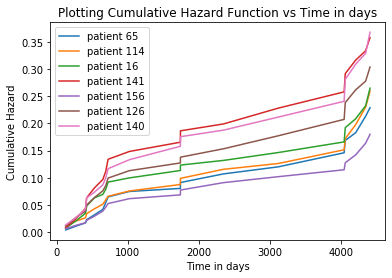

In [11]:
plt.figure()
for i, hazard in enumerate(chf[::15]):
    plt.plot(rsf.event_times_, hazard, label=f"patient {X_test.iloc[i].name}")
    
plt.xlabel("Time in days")
plt.ylabel("Cumulative Hazard")
plt.title("Plotting Cumulative Hazard Function vs Time in days")
plt.legend()


### Predicting and Plotting Survival Function

In [12]:
sf = rsf.predict_survival_function(X_test, return_array=True)
sf[:5]

array([[0.99568008, 0.98888596, 0.98296231, 0.97737296, 0.96889343,
        0.95954816, 0.94805331, 0.93919716, 0.93046274, 0.92570405,
        0.91671813, 0.90330904, 0.89352032, 0.87388594, 0.85830308,
        0.84697069, 0.82263163, 0.81132808],
       [0.98605807, 0.97463052, 0.96467175, 0.95142723, 0.93420644,
        0.92116433, 0.90975288, 0.89532222, 0.88104807, 0.86710398,
        0.85550811, 0.83394728, 0.82020773, 0.79308837, 0.7725343 ,
        0.75321506, 0.73152323, 0.70698621],
       [0.99137409, 0.97857003, 0.96421202, 0.95207964, 0.94026161,
        0.92993587, 0.91710137, 0.90402868, 0.89419121, 0.88531591,
        0.86961683, 0.86143315, 0.84665132, 0.82846093, 0.81108397,
        0.79179934, 0.77590118, 0.75340918],
       [0.9866831 , 0.97319493, 0.96305484, 0.95192298, 0.94206395,
        0.92860599, 0.91790359, 0.90641599, 0.8963352 , 0.87945432,
        0.86807412, 0.86074056, 0.84817327, 0.83168262, 0.81308364,
        0.79703132, 0.78202239, 0.75182552],
    

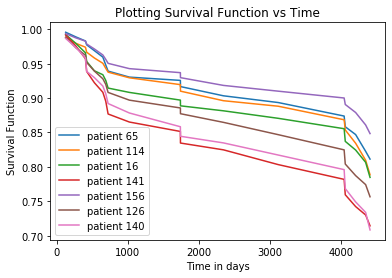

In [13]:
plt.figure()
for i, sfi in enumerate(sf[::15]):
    plt.plot(rsf.event_times_, sfi, label=f"patient {X_test.iloc[i].name}")
    
plt.xlabel("Time in days")
plt.ylabel("Survival Function")
plt.title("Plotting Survival Function vs Time")
plt.legend()

In [14]:
print("Risk scores")
risks = [rsf.predict(X_test.iloc[[i]])[0] for i in range(len(X_test[::15]))]
index = [X_test.iloc[i].name for i in range(len(X_test[::15]))]
pd.Series(data=risks, index=index)

Risk scores


65     1.663998
114    2.851931
16     2.424459
141    2.421694
156    1.286020
126    2.317410
140    2.119929
dtype: float64